https://www.researchgate.net/publication/280581078_Pseudo-Label_The_Simple_and_Efficient_Semi-Supervised_Learning_Method_for_Deep_Neural_Networks

WORK IN PROGRESS 

In [1]:
import os
import sys 
import datetime
import tensorboard
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.datasets import mnist

from keras import backend as K 
from keras import regularizers

import matplotlib.pyplot as plt
import random
import gc

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

(x_train, y_train), (x_test, y_test) = mnist.load_data()

device_name = tf.test.gpu_device_name()

Num GPUs Available:  1


In [2]:
def take_data(image, label, nb, size = 1):

  returned_label = []
  returned_image = []
  nb_elem_taken = 0
  idx = 0
  
  while  nb_elem_taken < size:

    if label[idx] == nb:
      returned_image.append(image[idx])
      returned_label.append(label[idx])
      image = np.delete(image, idx, axis=0)
      label = np.delete(label, idx, axis=0)
      nb_elem_taken += 1

    idx += 1

  return returned_image, returned_label, image, label

In [3]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.RandomTranslation( height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='reflect', interpolation='bilinear', seed=None, fill_value=0.0),
  layers.RandomZoom(.1, .1)
])

In [4]:
#take 100 images, labels

base_image = []
base_label = []

for i in range(10):
  new_image, new_label, x_train, y_train = take_data(x_train, y_train, nb=i, size=10)

  for nb in range(len(new_image)):
    base_image.append(new_image[nb])
    base_label.append(new_label[nb])

base_image = np.array(base_image)
base_label = np.array(base_label)
base_image = base_image.reshape(len(base_image),28,28,1)
base_label = keras.utils.to_categorical(base_label)

In [5]:
def createModel():

  model = Sequential()
  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = "softmax"))

  model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [6]:
model = createModel()

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    if tf.__version__[0] == '2':
        tf.random.set_seed(3)
    else:
        tf.set_random_seed(3)

x_test = x_test.reshape(len(x_test),28,28,1)
x_train = x_train.reshape(len(x_train),28,28,1)

y_test = keras.utils.to_categorical(y_test, num_classes=10)
y_train = keras.utils.to_categorical(y_train, num_classes=10) 

nbr_copy = 100

Xbase_train = base_image
Ybase_train = base_label

#data augmentation -- start
#Xbase_train = np.repeat(Xbase_train,nbr_copy, axis = 0)
#Ybase_train = np.repeat(Ybase_train,nbr_copy, axis = 0)

#Xbase_train = data_augmentation(Xbase_train)
#data augmentation -- end


x_train = np.delete(x_train, range(100), axis = 0)
y_train = np.delete(y_train, range(100))

previous_train_size = 0

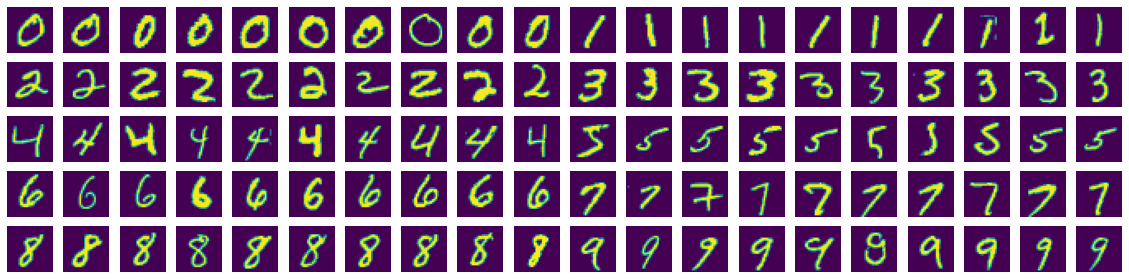

In [7]:
plt.figure(figsize=(20, 20))
for i in range(100):
  ax = plt.subplot(20, 20, i + 1)
  plt.imshow(tf.squeeze(Xbase_train[i]))
  plt.axis("off")

In [8]:
for i in range(30):

  nbr_to_add = previous_train_size

  #---- predict "nbr_image" new images
  new_images = x_train[:nbr_to_add]
  new_labels = np.array([])
  if i > 0 : #don't predict if the model has not been trained yet
    prob = model.predict(new_images)
    new_labels = prob.argmax(axis=-1)
    new_labels = keras.utils.to_categorical(new_labels, num_classes=10)

  #---- adding the datas in the train_sample
  Xtrain_sample = np.concatenate((Xbase_train,new_images), axis = 0)
  if i > 0:
    Ytrain_sample = np.concatenate((Ybase_train,new_labels), axis = 0)
  else:
    Ytrain_sample = Ybase_train
  
  #---- now that we have everything we must delete the old model to replace it with a new one
  del model
  K.clear_session()
  tf.compat.v1.reset_default_graph()
  reset_seeds()
  model = createModel()
  
  nb_epochs = 40 
  if nb_epochs - i*2 > 1:
    epochs = nb_epochs - i*2 
  else:
    epochs = 1
  #---- training the model
  model.fit(x = Xtrain_sample, 
            y = Ytrain_sample, 
            epochs = epochs, 
            validation_data=(x_test, y_test),
            batch_size = 64) 
  
  print("itération numéro : ", i+1)
  print("Xtrain_sample shape : ", Xtrain_sample.shape)

  previous_train_size = len(Xtrain_sample) * 1.5
  previous_train_size = round(previous_train_size)

  del Xtrain_sample
  del Ytrain_sample
  del new_images
  del new_labels

Epoch 1/40
2/2 [==============================] - 3s 1s/step - loss: 20.6205 - accuracy: 0.1000 - val_loss: 5.5448 - val_accuracy: 0.2001
Epoch 2/40
2/2 [==============================] - 1s 788ms/step - loss: 8.4085 - accuracy: 0.1500 - val_loss: 2.8227 - val_accuracy: 0.2265
Epoch 3/40
2/2 [==============================] - 1s 788ms/step - loss: 4.4335 - accuracy: 0.1700 - val_loss: 2.0912 - val_accuracy: 0.2634
Epoch 4/40
2/2 [==============================] - 1s 781ms/step - loss: 2.7310 - accuracy: 0.2300 - val_loss: 2.0587 - val_accuracy: 0.2858
Epoch 5/40
2/2 [==============================] - 1s 776ms/step - loss: 2.0332 - accuracy: 0.2800 - val_loss: 2.0781 - val_accuracy: 0.3660
Epoch 6/40
2/2 [==============================] - 1s 778ms/step - loss: 2.0372 - accuracy: 0.2700 - val_loss: 2.0866 - val_accuracy: 0.3337
Epoch 7/40
2/2 [==============================] - 1s 780ms/step - loss: 1.9653 - accuracy: 0.3200 - val_loss: 2.0706 - val_accuracy: 0.3573
Epoch 8/40
2/2 [======